# Code for text clustering analysis

In [1]:
#
# code for text clustering process
#

import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import json
import numpy as np
import plotly.express as px
import zipfile
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from collections import Counter
from scipy.sparse import vstack
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

## Internal Data Connector
import data_connector

# Data cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

def cluster_and_return(df, max_clusters=15, batch_size=10000):
    # Clean the text data
    df['cleaned_text'] = df['text_content'].apply(clean_text)
    
    # Initialize the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    
    # Fit the vectorizer on the entire dataset to establish the vocabulary
    vectorizer.fit(df['cleaned_text'])
    
    # Transform the data in batches
    n_batches = int(np.ceil(len(df) / batch_size))
    X = csr_matrix((0, len(vectorizer.vocabulary_)), dtype=np.float64)
    
    for i in range(n_batches):
        batch_texts = df['cleaned_text'][i * batch_size:(i + 1) * batch_size]
        X_batch = vectorizer.transform(batch_texts)
        X = vstack([X, X_batch])
    
    # Determine the optimal number of clusters using Elbow Method and Silhouette Score
    def determine_optimal_clusters(X, max_clusters):
        wcss = []
        silhouette_scores = []
        for i in range(2, max_clusters):  # start from 2 clusters
            kmeans = MiniBatchKMeans(n_clusters=i, random_state=42, batch_size=batch_size)
            kmeans.fit(X)
            wcss.append(kmeans.inertia_)
            if i > 1:
                silhouette_avg = silhouette_score(X, kmeans.labels_)
                silhouette_scores.append(silhouette_avg)

        # Determine optimal number of clusters based on highest silhouette score
        optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 because silhouette_scores starts from 2 clusters
        return optimal_clusters

    optimal_clusters = determine_optimal_clusters(X, max_clusters)
    print(f'Optimal number of clusters: {optimal_clusters}')

    # Perform clustering with the optimal number of clusters
    kmeans = MiniBatchKMeans(n_clusters=optimal_clusters, random_state=42, batch_size=batch_size)
    kmeans.fit(X)
    df['cluster_no'] = kmeans.labels_

    # Calculate average similarity score for each cluster using sparse matrix operations
    cluster_scores = []
    cluster_avg_similarities = []

    for cluster in range(optimal_clusters):
        indices = np.where(kmeans.labels_ == cluster)[0]
        if len(indices) > 1:
            cluster_sim = cosine_similarity(X[indices])
            avg_sim = cluster_sim[np.triu_indices(len(indices), k=1)].mean()
        else:
            avg_sim = 1.0  # If there's only one member in the cluster, similarity is 1
        cluster_scores.extend([avg_sim] * len(indices))
        cluster_avg_similarities.append(avg_sim)

    df['cluster_score'] = cluster_scores

    # calculate the PCA metric
    X = TfidfVectorizer(max_features=1000).fit_transform(df['text_content'])
    pca = PCA(n_components=2, random_state=42)
    pca_components = pca.fit_transform(X.toarray())
    df['pca1'] = pca_components[:, 0]
    df['pca2'] = pca_components[:, 1]

    # Drop the temporary cleaned_text column
    df = df.drop(columns=['cleaned_text'])

    # Return the updated DataFrame and cluster average similarities
    return df, cluster_avg_similarities



# Get The Jobs List

In [2]:
#
# get jobs
# 
strSQL = """
select 	a.id as jobsid,
        a.*,
		d.id as key_monitoring_media_social, 
		e.id as key_monitoring_media_online,
		c.*
from screen_analisis_ai a 
	inner join monitoring_search c 
		on cast(c.monitoring_id as varchar) = cast(a.monitoring_id as varchar) 
	left join monitoring_media_social d
		on d.monitoring_id = c.monitoring_id
	left outer join monitoring_media_online e
		on e.monitoring_id = c.monitoring_id 
where   c.monitoring_id = 'c5655c78-bbdd-4090-8e8a-b410b9b157d1'
"""

df_job = data_connector.execute_query_psql(strSQL)
if len(df_job) == 0:
    # get out, nothing to do
    print('Zero jobs, quitting now')
    quit()
    
similarity_treshold = 0.9
i_process_id = df_job['jobsid'][0]
screen_name = ''
database_keyword_id = df_job['key_monitoring_media_social'][0]
social_media_monitoring_id = df_job['key_monitoring_media_social'][0]
media_online_monitoring_id = df_job['key_monitoring_media_online'][0]

# print(database_keyword_id)
print(similarity_treshold)
print(i_process_id)
print(social_media_monitoring_id)
print(media_online_monitoring_id)


# Prepare SQL Statement
print(i_process_id)
sql = "update screen_analisis_ai set status = 2, last_status_update = now(), start_process = now() where id = %s"
sql = sql.replace('%s', str(i_process_id))

print(sql)
# row_count = data_connector.execute_query_psql(sql)
# print('update ' + str(row_count) + ' rows')


0.9
7362
eb13c01f-69c9-462b-9753-55d60ed4cc72
2e5024bb-a9f6-4c8c-b1a3-4671603223e1
7362
update screen_analisis_ai set status = 2, last_status_update = now(), start_process = now() where id = 7362


# Executing Text Clustering

In [3]:
# # prepare function to record result
# def record_result(result_df, cluster_avg_similarities, i_platform_id):
#     # result_df, cluster_avg_similarities
#     for i in range(0, len(result_df)):
#         ssql = """
#         insert into ret_cluster_result_monitor (ref_id, cluster_no, platform_id,
#         job_id, cluster_score,pca_1, pca_2) 
#         values ('%s',%s, %s, %s, %s, '%s', '%s')
#         """

#         # builds str 
#         ssql = ssql % (str(result_df['ref_id'][i]), str(result_df['cluster_no'][i]), str(i_platform_id), str(i_process_id), str(cluster_avg_similarities[result_df['cluster_no'][i]]), str(result_df['pca1'][i]), str(result_df['pca2'][i]))
#         # print(ssql)
#         data_connector.execute_query_psql(ssql)

# # Processing jobs for each platform
# import logging
# import psycopg2
# from psycopg2 import sql

# # Configure logging
# logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

# # Define a function to log errors to PostgreSQL
# def log_error_to_postgresql(message):
#     ssql = """
#     insert into ret_analysis_parameter (job_id, param_id, param_name ,param_value)
#     values (%s, %s, '%s', '%s')
#     """ % (i_process_id, 99, 'ERR', message)
    
#     # print(ssql)
#     data_connector.execute_query_psql(ssql)

# # Function to check the DataFrame size and throw an error if it contains less than 100 rows
# def check_dataset_size(df):
#     if len(df) < 100:
#         raise ValueError("dataset population less than 100 (%s), stopping jobs" % str(len(df)))

# # Processing jobs for each platform
# # 10 = tiktok
# # 20 = youtube
# # 30 = instagram_post
# # 40 = facebook_post
# # 50 = google_result
# # 60 = twitter_tweets

# iRowCount = 0

# try:
#     if df_job['is_tiktok'][0]:
#         sql_query = '''
#         select id as ref_id, "desc" as text_content 
#         from tiktok 
#         where monitoring_id = '%s' -- 10
#         '''
#         i_platform_id = 10
#         df = data_connector.execute_query_psql(sql_query % (social_media_monitoring_id))
#         check_dataset_size(df)
#         if len(df) != 0:
#             result_df, cluster_avg_similarities = cluster_and_return(df)
#             record_result(result_df, cluster_avg_similarities, i_platform_id)
#             iRowCount = iRowCount + len(df)
# except Exception as e:
#     error_message = f"Error processing TikTok data: {str(e)}"
#     logging.error(error_message)
#     log_error_to_postgresql(error_message)

# try:
#     if df_job['is_youtube'][0]:
#         sql_query = '''
#         select id as ref_id, title as text_content
#         from youtube 
#         where monitoring_id = '%s' -- 20
#         '''
#         i_platform_id = 20
#         df = data_connector.execute_query_psql(sql_query % (social_media_monitoring_id))
#         check_dataset_size(df)
#         if len(df) != 0:
#             result_df, cluster_avg_similarities = cluster_and_return(df)
#             record_result(result_df, cluster_avg_similarities, i_platform_id)
#             iRowCount = iRowCount + len(df)
# except Exception as e:
#     error_message = f"Error processing YouTube data: {str(e)}"
#     logging.error(error_message)
#     log_error_to_postgresql(error_message)

# try:
#     if df_job['is_instagram'][0]:
#         sql_query = '''
#         select id as ref_id, content as text_content
#         from instagram_post 
#         where monitoring_id = '%s' -- 30
#         '''
#         i_platform_id = 30
#         df = data_connector.execute_query_psql(sql_query % (social_media_monitoring_id))
#         check_dataset_size(df)
#         if len(df) != 0:
#             result_df, cluster_avg_similarities = cluster_and_return(df)
#             record_result(result_df, cluster_avg_similarities, i_platform_id)
#             iRowCount = iRowCount + len(df)
# except Exception as e:
#     error_message = f"Error processing Instagram data: {str(e)}"
#     logging.error(error_message)
#     log_error_to_postgresql(error_message)

# try:
#     if df_job['is_facebook'][0]:
#         sql_query = '''
#         select id as ref_id, "description" as text_content
#         from facebook_post 
#         where monitoring_id = '%s' -- 40
#         and length(trim("description")) > 0
#         '''
#         i_platform_id = 40
#         df = data_connector.execute_query_psql(sql_query % (social_media_monitoring_id))
#         check_dataset_size(df)
#         if len(df) != 0:
#             result_df, cluster_avg_similarities = cluster_and_return(df)
#             record_result(result_df, cluster_avg_similarities, i_platform_id)
#             iRowCount = iRowCount + len(df)
# except Exception as e:
#     error_message = f"Error processing Facebook data: {str(e)}"
#     logging.error(error_message)
#     log_error_to_postgresql(error_message)

# try:
#     if df_job['is_google'][0]:
#         sql_query = '''
#             select id as ref_id, "description" as text_content
#             from google_result 
#             where monitoring_id = '%s' -- 50
#         '''
#         i_platform_id = 50
#         df = data_connector.execute_query_psql(sql_query % (media_online_monitoring_id))
#         check_dataset_size(df)
#         if len(df) != 0:
#             result_df, cluster_avg_similarities = cluster_and_return(df)
#             record_result(result_df, cluster_avg_similarities, i_platform_id)
#             iRowCount = iRowCount + len(df)
# except Exception as e:
#     error_message = f"Error processing Google data: {str(e)}"
#     logging.error(error_message)
#     log_error_to_postgresql(error_message)

# try:
#     if df_job['is_twitter'][0]:
#         sql_query = '''
#         select id as ref_id, tweet as text_content
#         from twitter_tweets 
#         where monitoring_id = '%s' -- 60
#         '''
#         i_platform_id = 60
#         df = data_connector.execute_query_psql(sql_query % (social_media_monitoring_id))
#         check_dataset_size(df)
#         if len(df) != 0:
#             result_df, cluster_avg_similarities = cluster_and_return(df)
#             record_result(result_df, cluster_avg_similarities, i_platform_id)
#             iRowCount = iRowCount + len(df)
# except Exception as e:
#     error_message = f"Error processing Twitter data: {str(e)}"
#     logging.error(error_message)
#     log_error_to_postgresql(error_message)

# print("Total Processed Data: " + str(iRowCount))



# Code for image cluster analysis

In [4]:
#
# code for image clustering
#

import pandas as pd
import numpy as np
import requests
from collections import defaultdict
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from urllib.parse import urlsplit, urlunsplit
import data_connector
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import cv2

# Load a pre-trained VGG16 model without the top layer (output layer)
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 1: Data Loading and Cleaning
def load_image(url, url_prefix, size=(512, 512)):
    # Remove the filename extension
    parts = list(urlsplit(url))
    path = parts[2]
    path = '/'.join(part.rsplit('.', 1)[0] for part in path.split('/'))
    parts[2] = path
    url = urlunsplit(parts)

    # Add the URL prefix
    full_url = url_prefix + url
    # print(full_url)

    response = requests.get(full_url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(size)
    img = np.array(img)

    if len(img.shape) == 2:  # Grayscale image
        img = np.stack([img] * 3, axis=-1)  # Convert to RGB by stacking the grayscale values
    
    if (len(img.shape)) > 2:
        if img.shape[2] == 4:
            img = img[:, :, :3]  # Remove alpha channel if present
    img = img / 255.0  # Normalize
    return img

# Step 2: Feature Extraction
def extract_features(img):
    h, w, c = img.shape
    return img.reshape(1, h * w * c)

def extract_features_cnn(img):
    # Resize the image to the input size expected by VGG16
    img_resized = cv2.resize(img, (224, 224))
    
    # Convert to array and preprocess for VGG16
    img_array = img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Extract features using VGG16
    features = model.predict(img_array)
    
    # Flatten the feature maps
    features = features.flatten()
    
    return features.reshape(1, -1)


# Main function to execute the steps
def main(df, url_column, url_prefix):
    all_features = []
    for url in df[url_column]:
        #print(url)
        img = load_image(url, url_prefix)
        features = extract_features_cnn(img)
        all_features.append(features)
    all_features = np.vstack(all_features)

    # Determine optimal clusters
    # print(all_features)
    optimal_clusters, inertia, silhouette_scores = determine_optimal_clusters(all_features)
    if optimal_clusters is None:
        print("Could not determine optimal clusters due to insufficient unique labels.")
        return []

    print('Optimal Cluster %s' % (optimal_clusters))
    cluster_labels, kmeans = perform_clustering(all_features, optimal_clusters)
    print_cluster_content(cluster_labels)
    pca_result = visualize_clusters(all_features, cluster_labels)
    output = prepare_output(cluster_labels, pca_result, all_features)
    outputlist = prepare_output_final(output)
    
    # Calculate average distance from centroid for each cluster
    average_distances = average_distance_from_centroid(outputlist)
    score = normalize_distances(average_distances)
    print('score')
    print(score)

    # output_final = prepare_output_final(output,score)

    return output, optimal_clusters, inertia, silhouette_scores, outputlist, score

# Step 3: Optimal Cluster Determination
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

def determine_optimal_clusters(features, max_clusters=15):
    inertia = []
    silhouette_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    range_n_clusters = list(range(2, min(max_clusters, len(features))))

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(features)
        inertia.append(kmeans.inertia_)

        # Calculate silhouette score only if there is more than one cluster
        if len(np.unique(cluster_labels)) > 1:
            silhouette_scores.append(silhouette_score(features, cluster_labels))
            calinski_harabasz_scores.append(calinski_harabasz_score(features, cluster_labels))
            davies_bouldin_scores.append(davies_bouldin_score(features, cluster_labels))
        else:
            silhouette_scores.append(-1)
            calinski_harabasz_scores.append(float('inf'))  # Davies-Bouldin prefers smaller values
            davies_bouldin_scores.append(float('inf'))

    # If all silhouette scores are -1, return None
    if all(score == -1 for score in silhouette_scores):
        return None, inertia, silhouette_scores

    # Normalize the metrics for better comparison
    silhouette_scores = np.array(silhouette_scores)
    silhouette_scores = (silhouette_scores - silhouette_scores.min()) / (silhouette_scores.max() - silhouette_scores.min())

    calinski_harabasz_scores = np.array(calinski_harabasz_scores)
    calinski_harabasz_scores = (calinski_harabasz_scores - calinski_harabasz_scores.min()) / (calinski_harabasz_scores.max() - calinski_harabasz_scores.min())

    davies_bouldin_scores = np.array(davies_bouldin_scores)
    davies_bouldin_scores = (davies_bouldin_scores.max() - davies_bouldin_scores) / (davies_bouldin_scores.max() - davies_bouldin_scores.min())  # Invert because lower is better

    # Aggregate the scores
    combined_scores = silhouette_scores + calinski_harabasz_scores + davies_bouldin_scores

    # Find the optimal number of clusters with the highest combined score
    optimal_clusters = range_n_clusters[np.argmax(combined_scores)]

    # Optional: plot inertia, silhouette scores, and combined scores for visualization
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(range_n_clusters, inertia, marker='o')
    plt.title('Inertia (Elbow Method)')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

    plt.subplot(1, 3, 2)
    plt.plot(range_n_clusters, silhouette_scores, marker='o', label='Silhouette')
    plt.plot(range_n_clusters, calinski_harabasz_scores, marker='x', label='Calinski-Harabasz')
    plt.plot(range_n_clusters, davies_bouldin_scores, marker='s', label='Davies-Bouldin')
    plt.title('Individual Scores')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Normalized Score')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range_n_clusters, combined_scores, marker='o')
    plt.title('Combined Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Combined Score')

    plt.tight_layout()
    plt.show()

    # return optimal_clusters, inertia, silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores, combined_scores
    return optimal_clusters, inertia, combined_scores #, calinski_harabasz_scores, davies_bouldin_scores, combined_scores

# Step 4: Clustering
def perform_clustering(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(features)
    return cluster_labels, kmeans

# Step 5: Print Cluster Content
def print_cluster_content(cluster_labels):
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        print(f"Cluster {label}: {np.sum(cluster_labels == label)} members")

# Step 6: PCA Scatter Plot
def visualize_clusters(features, cluster_labels):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Clusters Visualization with PCA')
    # plt.show()
    return pca_result

# Step 7: Prepare Output
def prepare_output(cluster_labels, pca_result, features):
    output = []
    unique_labels = np.unique(cluster_labels)
    
    for label in unique_labels:
        members = np.where(cluster_labels == label)[0].tolist()
        cluster_pca1 = pca_result[cluster_labels == label, 0].tolist()
        cluster_pca2 = pca_result[cluster_labels == label, 1].tolist()
        cluster_features = features[cluster_labels == label]
        
        # Check if the cluster contains more than one unique point
        if len(cluster_features) > 1:
            # Check if the number of unique labels is more than one before calculating silhouette score
            if len(np.unique(cluster_labels)) > 1:
                try:
                    similarity_score = silhouette_score(cluster_features, [label] * len(cluster_features))
                except ValueError:
                    similarity_score = -1
            else:
                similarity_score = -1  # Set to -1 if silhouette score can't be calculated
        else:
            similarity_score = -1  # Set to -1 if there is only one point in the cluster
        
        output.append({
            'cluster': label,
            'members': members,
            'pca1': cluster_pca1,
            'pca2': cluster_pca2,
            'similarity_score': similarity_score
        })
    
    # Convert to DataFrame
    df_output = pd.DataFrame(output)
    
    # Convert DataFrame to list
    list_output = df_output.to_numpy().tolist()
    
    return list_output


# Function to compute the centroid of a cluster
def compute_centroid(points):
    points = np.array(points)
    return np.mean(points, axis=0)

# Function to calculate the Euclidean distance
def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

# Function to compute the average distance from the centroid for each cluster
def average_distance_from_centroid(data):
    clusters = defaultdict(list)
    
    # Grouping points by cluster number
    for entry in data:
        _, _, cluster_number, PCA1, PCA2 = entry
        clusters[cluster_number].append((PCA1, PCA2))
    
    average_distances = {}
    
    for cluster_number, points in clusters.items():
        centroid = compute_centroid(points)
        total_distance = sum(euclidean_distance(point, centroid) for point in points)
        average_distance = total_distance / len(points)
        average_distances[cluster_number] = average_distance
    
    return average_distances

# Function to normalize the distances to a score between 0 and 1
def normalize_distances(average_distances):
    min_distance = min(average_distances.values())
    max_distance = max(average_distances.values())
    
    normalized_scores = {}
    for cluster_number, avg_distance in average_distances.items():
        if max_distance == min_distance:  # Avoid division by zero
            normalized_scores[cluster_number] = 0.0
            normalized_scores[cluster_number] = 1 - normalized_scores[cluster_number]
        else:
            normalized_scores[cluster_number] = (avg_distance - min_distance) / (max_distance - min_distance)
            normalized_scores[cluster_number] = 1 - normalized_scores[cluster_number]
    
    return normalized_scores

def prepare_output_final(output):
    # create list of:
    memberIdx = 0
    outputlist = []
    
    for i in range(len(output)):
        # 0: cluster number
        # 1: member
        # 2: PCA1
        # 3: PCA2
        # 4: Sim Score ->> from score list
        
        # iterate thru member
        for j in range(len(output[i][1])):
            memberIndex = output[i][1][j]
            PCA1 = output[i][2][j]
            PCA2 = output[i][3][j]
            clusterId = output[i][0]
            # simScore = output[i][4][j]
            key_id = result_df['key_id'][memberIndex]
            
            # print(key_id, memberIndex, clusterId, PCA1, PCA2, simScore)
            outputlist.append([key_id, memberIndex, clusterId, PCA1, PCA2])
    
    return outputlist

def recording_output(output_final, score, platform_id):
# id, ref_id, cluster_no, platform_id, job_id
    query_sql = """
    insert into ret_cluster_image_result_monitor 
    (ref_id, cluster_no, platform_id, job_id, pca1, pca2, score)
    """

    for i in range(len(output_final)):
        sim_score = score[output_final[i][2]]
        valuesql = "values ( '" + str(output_final[i][0]) + "','" + str(output_final[i][2])  + "','" + str(platform_id) + "','" + str(i_process_id) + "','"+ str(output_final[i][3]) +"','" + str(output_final[i][4]) + "','" + str(sim_score) + "' )"
        ssql = query_sql + valuesql
        # print(ssql)
        data_connector.execute_query_psql(ssql)
        


2024-08-21 17:35:52.566144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 17:35:52.584606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 17:35:52.590269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 17:35:52.603557: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 17:35:53.402346: W tensorflow/compiler/tf2

# Executing Image Clustering


    select 	a.id as key_id,
            b.filename as filename
    from 	twitter_tweets a inner join media_files b 
            on a.id = b.tweet_id
    where a.monitoring_id = 'eb13c01f-69c9-462b-9753-55d60ed4cc72'
    
https://disestages.com/api/media/photo/download/twitter/
Processing 118 twitter image post


I0000 00:00:1724261756.210315  134024 service.cc:146] XLA service 0x7fc4ac0063a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724261756.210354  134024 service.cc:154]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-08-21 17:35:56.218559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-21 17:35:56.289830: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8903


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


I0000 00:00:1724261756.805731  134024 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

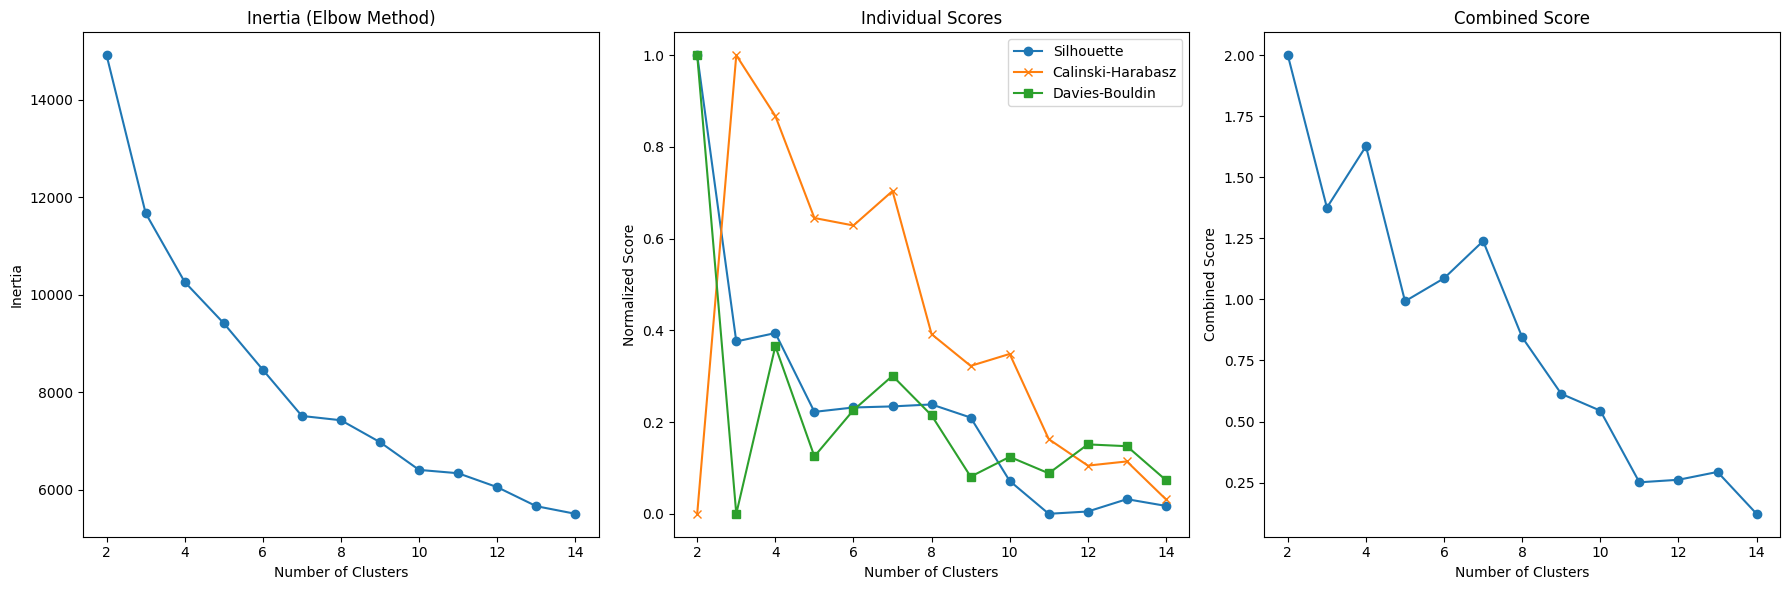

Optimal Cluster 2
Cluster 0: 73 members
Cluster 1: 45 members
score
{0: 1.0, 1: 0.0}

    select 	a.id as key_id,
            b.filename as filename
    from 	tiktok a inner join media_files_tiktok b 
            on a.id = b.tiktok_id 
    where a.monitoring_id = 'eb13c01f-69c9-462b-9753-55d60ed4cc72'
    
https://disestages.com/api/media/photo/download/tiktok/


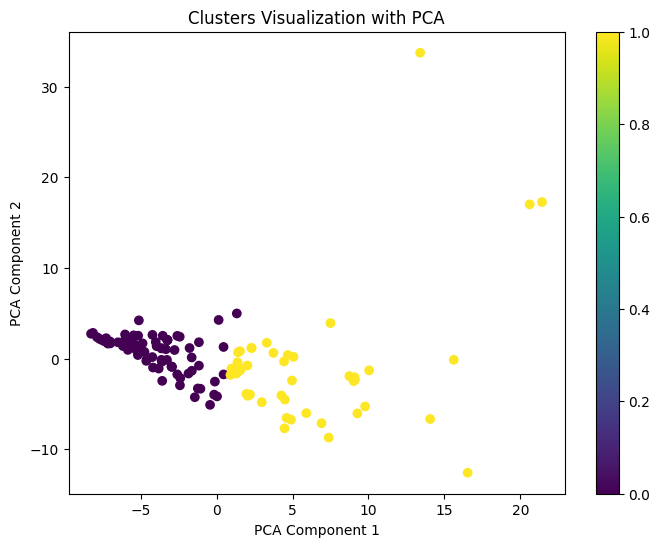

In [5]:
img_prefix_http = "https://disestages.com/api/media/photo/download/%s/"

# Processing jobs for each platform
# 10 = tiktok
# 20 = youtube
# 30 = instagram_post
# 40 = facebook_post
# 50 = google_result
# 60 = twitter_tweets

iRowCount = 0

if (df_job['is_twitter'][0]):
    ssql = """
    select 	a.id as key_id,
            b.filename as filename
    from 	twitter_tweets a inner join media_files b 
            on a.id = b.tweet_id
    where a.monitoring_id = '%s'
    """
    ssql = ssql % (social_media_monitoring_id)
    print(ssql)
    img_prefix_http = "https://disestages.com/api/media/photo/download/%s/"
    img_prefix_http = img_prefix_http % "twitter"
    print(img_prefix_http)
    
    result_df = data_connector.execute_query_psql(ssql)
    if (len(result_df)) > 0:
        print("Processing %s twitter image post" % (len(result_df)))
        # processing
        output, optimal_clusters, inertia, silhouette_scores, output_final, score = main(result_df, 'filename', img_prefix_http)
        # Recording Result
        recording_output(output_final, score, 60)
        iRowCount = iRowCount + len(output_final)

if (df_job['is_tiktok'][0]):
    ssql = """
    select 	a.id as key_id,
            b.filename as filename
    from 	tiktok a inner join media_files_tiktok b 
            on a.id = b.tiktok_id 
    where a.monitoring_id = '%s'
    """
    ssql = ssql % (social_media_monitoring_id)
    print(ssql)
    img_prefix_http = "https://disestages.com/api/media/photo/download/%s/"
    img_prefix_http = img_prefix_http % "tiktok"
    print(img_prefix_http)
    
    result_df = data_connector.execute_query_psql(ssql)
    if (len(result_df)) > 0:
        print("Processing %s tiktok image post" % (len(result_df)))
        # processing
        output, optimal_clusters, inertia, silhouette_scores, output_final, score = main(result_df, 'filename', img_prefix_http)
    
        # Recording Result
        recording_output(output_final, score, 10)
        iRowCount = iRowCount + len(output_final)
    
elif (df_job['is_facebook'][0]):
    ssql = """
    select 	a.id as key_id,
            b.filename as filename
    from 	facebook_post a inner join media_files_facebook b
    		on a.id = b.facebook_id 
    where a.monitoring_id = '%s'
    """
    ssql = ssql % (social_media_monitoring_id)
    print(ssql)

    img_prefix_http = "https://disestages.com/api/media/photo/download/%s/"
    img_prefix_http = img_prefix_http % "facebook"
    print(img_prefix_http)
    
    result_df = data_connector.execute_query_psql(ssql)
    
    if (len(result_df)) > 0:
        print("Processing %s facebook image post" % (len(result_df)))
        # processing
        output, optimal_clusters, inertia, silhouette_scores, output_final, score = main(result_df, 'filename', img_prefix_http)
    
        # Recording Result
        recording_output(output_final, score, 40)
        iRowCount = iRowCount + len(output_final)

    

# Push to Central Table

In [6]:
import psycopg2
from tqdm.notebook import tqdm

# Database connection configuration
DB_CONFIG = {
    'dbname': 'medols',
    'user': 'postgres',
    'password': 'FEWcTB3JIX5gK4T06c1MdkM9N2S8w9pb',
    'host': '98.98.117.105',
    'port': '5432'
}

def connect_db():
    return psycopg2.connect(**DB_CONFIG)

def run_insert_statements(monitoring_id):
    # Delete existing records for this monitoring_id
    delete_query = f"DELETE FROM social_media_activity WHERE monitoring_id_platform_data = '{monitoring_id}';"
    
    queries = [
        # Insert from vw_monitoring_facebook
        f"""
        INSERT INTO social_media_activity (
        monitoring_id_platform_data, name, description, created_date_platform_data,
        post_date, user_id_platform_data, profile_id, likes_count, shares_count,
        views_count, comment_count, sentiment_id, sentiment_category, sentiment_score,
        post_url, profile_url, cluster_no, cluster_score, pca_1, pca_2,
        iskol, img_cluster_no, img_pca_1, img_pca_2, img_cluster_score,
        table_name_platform_data, image_filename, following_count, follower_count, 
        subscriber_count, fullname  )
        SELECT monitoring_id, name, description, created_date, post_date,
        user_id, profile_id, likes_count, shares_count, views_count,
        comment_count, sentiment_id, sentiment_category, score AS sentiment_score,
        post_url, profile_url, cluster_no, cluster_score, pca_1, pca_2, iskol,
        img_cluster_no, img_pca_1, img_pca_2, img_cluster_score, 'vw_monitoring_facebook', filename,
        following_count, follower_count, friend_count, fullname
        FROM vw_monitoring_facebook
        WHERE monitoring_id = '{monitoring_id}';
        """,
        
        # Insert from vw_monitoring_google
        f"""
        INSERT INTO social_media_activity (
        monitoring_id_platform_data, source, description, created_date_platform_data,
        publish_date, updated_date_platform_data, link_url, content,
        title_platform_data, sentiment_category, sentiment_score, sentiment_id,
        cluster_no, cluster_score, pca_1, pca_2, img_cluster_no,
        img_cluster_score, img_pca_1, img_pca_2, table_name_platform_data)
        SELECT monitoring_id, source, description, created_date,
        publish_date, updated_date, link, content, title,
        sentiment_category, score AS sentiment_score, sentiment_id,
        cluster_no, cluster_score, pca_1, pca_2,
        img_cluster_no, img_cluster_score, img_pca_1,
        img_pca_2, 'vw_monitoring_google' AS table_name_platform_data
        FROM vw_monitoring_google
        WHERE monitoring_id = '{monitoring_id}';
        """,
        
        # Insert from vw_monitoring_instagram
        f"""
        INSERT INTO social_media_activity (
        instagram_post_id, link_url, post_content, publish_date,
        like_count, shares_count, comment_count, created_date_platform_data,
        monitoring_id_platform_data, profile_id, fullname,
        username_platform_data, is_tc_completed, post_exclude,
        sentiment_id, sentiment_category, sentiment_score, cluster_no,
        cluster_score, pca_1, pca_2, iskol, img_cluster_no,
        img_cluster_score, img_pca_1, img_pca_2, table_name_platform_data)
        SELECT instagram_post_id, link_url, post_content, publish_date,
        like_count, shared_count AS shares_count, comment_count,
        created_date, monitoring_id, profile_id, fullname,
        username, is_tc_completed, post_exclude, sentiment_id,
        sentiment_category, sentiment_score, cluster_no, cluster_score,
        pca_1, pca_2, iskol,img_cluster_no, img_cluster_score,
        img_pca_1, img_pca_2, 'vw_monitoring_instagram'
        FROM vw_monitoring_instagram
        WHERE monitoring_id = '{monitoring_id}';
        """,
        
        # Insert from vw_monitoring_tiktok
        f"""
        INSERT INTO social_media_activity (
        tiktok_id, monitoring_id_platform_data,create_time, description,
        is_polri, tiktok_created_date, tiktok_updated_date, nickname,
        unique_id, comment_count, digg_count, play_count, share_count,
        sentiment_category, sentiment_score, sentiment_id, follower_count,
        following_count, heart_count, video_count, cluster_no, cluster_score,
        pca_1, pca_2, iskol, img_cluster_no,
        img_pca_1, img_pca_2, img_cluster_score, table_name_platform_data,
        image_filename)
        SELECT tiktok_id, monitoring_id, create_time, "desc" AS description,
        is_polri, tiktok_created_date, tiktok_updated_date,
        nickname, unique_id, comment_count, digg_count,
        play_count, share_count, sentiment_category, score AS sentiment_score,
        id AS sentiment_id, follower_count, following_count, heart_count,
        video_count, cluster_no, cluster_score, pca_1, pca_2,
        iskol, img_cluster_no, img_pca_1, img_pca_2,
        img_cluster_score, 'vw_monitoring_tiktok', filename
        FROM vw_monitoring_tiktok
        WHERE monitoring_id = '{monitoring_id}';
        """,
        
        # Insert from vw_monitoring_twitter
        f"""
        INSERT INTO social_media_activity (
        twitter_tweets_id, monitoring_id_platform_data, user_id_platform_data, date,
        time,timezone,screen_name,name,is_polri,is_tc_completed,original_tweet,
        tweet,replies_count,likes_count,retweets_count,view_count,follower_count,
        sentiment_category,sentiment_score,sentiment_id,cluster_no,cluster_score,
        pca_1,pca_2,iskol,img_cluster_no,img_pca_1,img_pca_2, img_cluster_score,
        table_name_platform_data, image_filename )
        SELECT twitter_tweets_id, monitoring_id, user_id, date, time,
        timezone, screen_name, name, is_polri, is_tc_completed, original_tweet,
        tweet, replies_count, likes_count, retweets_count, view_count,
        follower_count, sentiment_category, score AS sentiment_score, sentiment_id,
        cluster_no, cluster_score, pca_1, pca_2, iskol, img_cluster_no,
        img_pca_1, img_pca_2, img_cluster_score, 'vw_monitoring_twitter', filename
        FROM vw_monitoring_twitter
        WHERE monitoring_id = '{monitoring_id}';
        """,
        
        # Insert from vw_monitoring_youtube
        f"""
        INSERT INTO social_media_activity (
        id_platform_data, monitoring_id_platform_data, channel_id, title_platform_data,
        description, channel_name, published_date, publish_time, created_date_platform_data,
        view_count, like_count, favorite_count, comment_count, sentiment_id,
        sentiment_category, sentiment_score, cluster_no, cluster_score,
        pca_1, pca_2, subscriber_count, video_count, channel_created_date,
        iskol,img_cluster_no,img_pca_1, img_pca_2, img_cluster_score, 
        table_name_platform_data)
        SELECT id, monitoring_id, channel_id, title, description, channel_name,
        published_date, publish_time, created_date, view_count, like_count,
        favorite_count, comment_count, sentiment_id, sentiment_category,
        score AS sentiment_score, cluster_no, cluster_score, pca_1,
        pca_2, subscriber_count, video_count, channel_created_date,
        iskol, img_cluster_no, img_pca_1, img_pca_2, img_cluster_score, 
        'vw_monitoring_youtube'
        FROM vw_monitoring_youtube
        WHERE monitoring_id = '{monitoring_id}';
        """
    ]

    rows_affected = []

    try:
        conn = connect_db()
        with conn.cursor() as cur:
            # Execute delete query
            cur.execute(delete_query)
            print(f"Deleted existing records for monitoring_id: {monitoring_id}")
            
            for query in queries:
                cur.execute(query)
                rows_affected.append(cur.rowcount)
        conn.commit()
    except Exception as e:
        print(f"An error occurred: {e}")
        conn.rollback()
    finally:
        conn.close()

    return rows_affected

# Process key_monitoring_media_online if not null
if media_online_monitoring_id:
    print(f"Processing key_monitoring_media_online: {media_online_monitoring_id}")
    rows_inserted = run_insert_statements(media_online_monitoring_id)
    print(f"Rows affected for key_monitoring_media_online {media_online_monitoring_id}: {rows_inserted}")

# Process key_monitoring_media_social if not null
if social_media_monitoring_id:
    print(f"Processing key_monitoring_media_social: {social_media_monitoring_id}")
    rows_inserted = run_insert_statements(social_media_monitoring_id)
    print(f"Rows affected for key_monitoring_media_social {social_media_monitoring_id}: {rows_inserted}")


Processing key_monitoring_media_online: 2e5024bb-a9f6-4c8c-b1a3-4671603223e1
Deleted existing records for monitoring_id: 2e5024bb-a9f6-4c8c-b1a3-4671603223e1
Rows affected for key_monitoring_media_online 2e5024bb-a9f6-4c8c-b1a3-4671603223e1: [0, 200, 0, 0, 0, 0]
Processing key_monitoring_media_social: eb13c01f-69c9-462b-9753-55d60ed4cc72
Deleted existing records for monitoring_id: eb13c01f-69c9-462b-9753-55d60ed4cc72
Rows affected for key_monitoring_media_social eb13c01f-69c9-462b-9753-55d60ed4cc72: [0, 0, 4461, 0, 123, 0]


# Marking job is done

In [7]:
# # Finishing Jobs
# # Create Parameter Record
# sql = "insert into ret_analysis_parameter (job_id, param_id, param_name, param_value) values (%s, %s, %s, %s)"
# # Execute the query
# data_connector.execute_query_psql(sql % (i_process_id, 1, "'#Content Processed'",iRowCount))

# # Create Tweet Cluster Record
# sql = "update ret_analysis_header set datetime_finish = NOW() where job_id = %s"
# # Executing query
# data_connector.execute_query_psql(sql % (i_process_id) )

# sql = "update screen_analisis_ai set status = 3, duration = EXTRACT(EPOCH FROM (now() - start_process)), end_process = NOW() where id = %s"
# data_connector.execute_query_psql(sql % (i_process_id))

# print('inserting result finished')